# Notebook Summary
In this notebook I test various basic models on the data

In [1]:
import autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import Classes

In [2]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Pickle in Data

In [3]:
# Pickle in cleaned dataframe

# Designate path

path = r"C:\Users\Andrew\Documents\Metis\TikTok_Song_Predictor\Pickle\df_agg.pkl"

df = pickle.load(open(path,'rb'))
df.head(2)

,level_0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,TikTok Link,Release Date,Position Change,spotify_uri,audio_analysis,feature_analysis,success,year,top_albums,top_artists
0,0,0.880,0.501,2.0,-6.774,1.0,0.062,0.0494,0.0695,0.4360,...,https://www.tiktok.com/music/All-TikTok-Mashup...,2020-08-17,23.0,5TpvLkESnw1g9wDz52efeO,"{'meta': {'analyzer_version': '4.0.0', 'platfo...","{'danceability': 0.88, 'energy': 0.501, 'key':...",1,2020.0,Other,Other
1,162,0.935,0.454,1.0,-7.509,1.0,0.375,0.0194,0.0000,0.0824,...,https://www.tiktok.com/music/WAP-Megan-Thee-St...,2018-03-22,15.0,4Oun2ylbjFKMPTiaSbbCih,"{'meta': {'analyzer_version': '4.0.0', 'platfo...","{'danceability': 0.935, 'energy': 0.454, 'key'...",1,2018.0,Other,Cardi B


# 1) Initial Logistic Regression

In [4]:
# Seperate features from label

X = df.loc[:,['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','year']]

y = df['success']

In [5]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [6]:
# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [7]:
# run initial logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall val")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  87.67%
Val set score:  87.62%

Precision / Recall val
Val F1 score:   0.00%
Precision: 0.0000,   Recall: 0.0000


C:\Users\Andrew\anaconda3\envs\spark\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


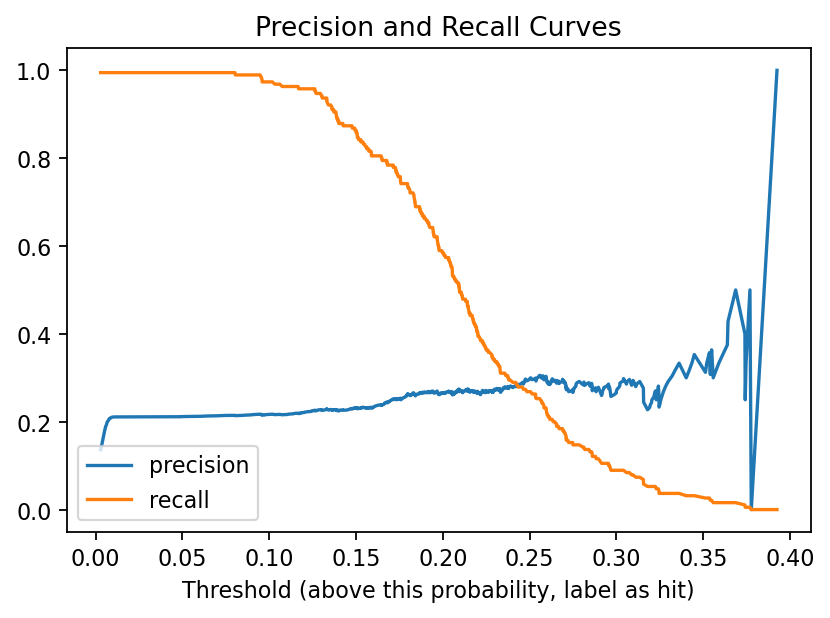

In [8]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as hit)');
plt.title('Precision and Recall Curves');

## These initial results are okay - let's try oversampling 

In [9]:
# Seperate features from label

X = df.loc[:,['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','year']]

y = df['success']

In [10]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

In [11]:
ada = ADASYN(random_state=42)

In [12]:
# Oversample training data
X_adasyn_tr, y_adasyn_tr = ada.fit_resample(X_train,y_train)

In [13]:
Counter(y_adasyn_tr)

Counter({0: 4037, 1: 4091})

In [14]:
# Scale features 
scaler = StandardScaler()
X_adasyn_tr = scaler.fit_transform(X_adasyn_tr)
X_val = scaler.transform(X_val)

In [15]:
# run logistic regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_adasyn_tr, y_adasyn_tr)
y_predict = lr.predict(X_val)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_adasyn_tr, y_adasyn_tr)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(f1_score(lr.predict(X_val), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  74.56%
Val set score:  58.11%

Precision / Recall
Val F1 score:   0.34%
Precision: 0.2137,   Recall: 0.8895


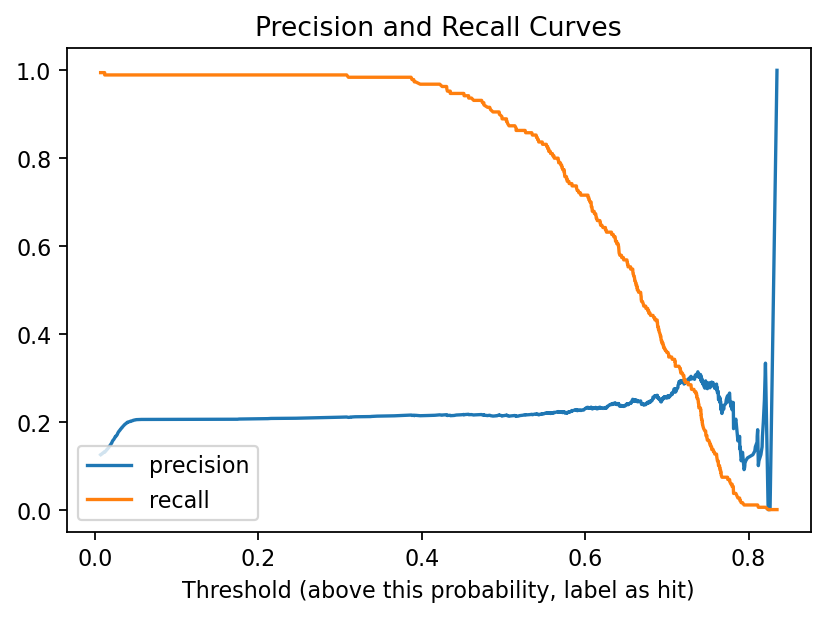

In [16]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as hit)');
plt.title('Precision and Recall Curves');

# Appling PCA & Oversampling

In [17]:
# Seperate features from label

X = df.loc[:,['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','year']]

y = df['success']

In [18]:
# Oversample

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train)

ada = ADASYN(random_state=42)

# Oversample training data
X_adasyn_tr, y_adasyn_tr = ada.fit_resample(X_train,y_train)

In [19]:
# Scale features 
scaler = StandardScaler()
X_adasyn_tr = scaler.fit_transform(X_adasyn_tr)
X_val = scaler.transform(X_val)

In [20]:
# Determining number of PCA components for 95% of variation
pca = PCA()
X_pca = pca.fit_transform(X_adasyn_tr)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X.shape[1] - n_over_95 + 1

In [21]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression()
pca = PCA(n_components=n_to_reach_95)

In [22]:
# fit logistic regression and pca
X_pca_train = pca.fit_transform(X_adasyn_tr)
lr.fit(X_pca_train, y_adasyn_tr) # fit to train

LogisticRegression(max_iter=10000)

In [23]:
# transform val data with pca

X_val_pca = pca.transform(X_val)

In [24]:
y_val.unique()

array([0, 1])

In [25]:
# Test regression
y_predict = lr.predict(X_val_pca)

#scores
print("Scores for the logisitc regression")
print("Training score: {:6.2f}%".format(100*lr.score(X_pca_train, y_adasyn_tr)))
print("Val set score: {:6.2f}%".format(100*lr.score(X_val_pca, y_val)))

#precision/recall
print("\nPrecision / Recall")
print("Val F1 score: {:6.2f}%".format(100*f1_score(lr.predict(X_val_pca), y_val)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(100*precision_score(y_val, y_predict), 
                                                     100*recall_score(y_val, y_predict)))

Scores for the logisitc regression
Training score:  73.92%
Val set score:  55.70%

Precision / Recall
Val F1 score:  34.24%
Precision: 20.9716,   Recall: 93.1579


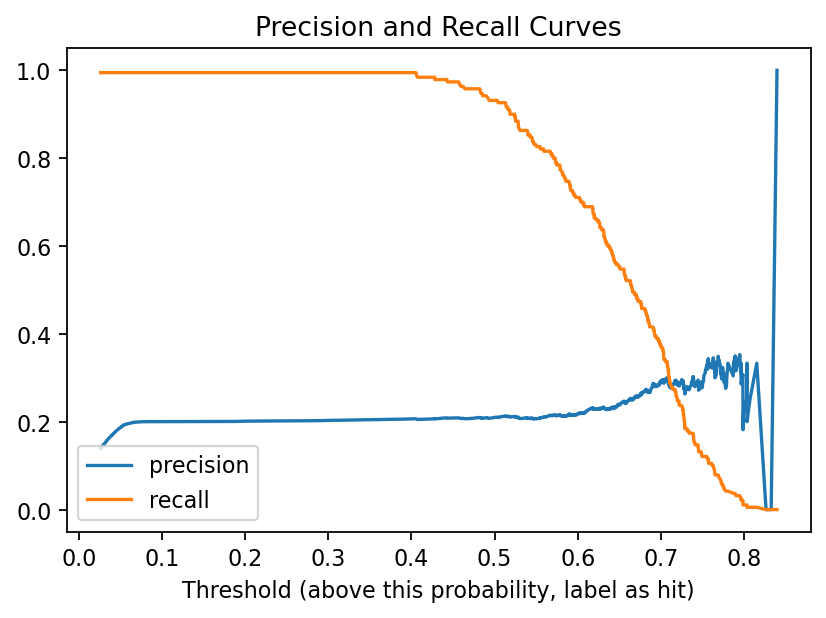

In [26]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val_pca)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as hit)');
plt.title('Precision and Recall Curves');